In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

[16666.66666667 16666.66666667 16666.66666667 ... 24999.99999873
 25000.00000095 16666.66666631]


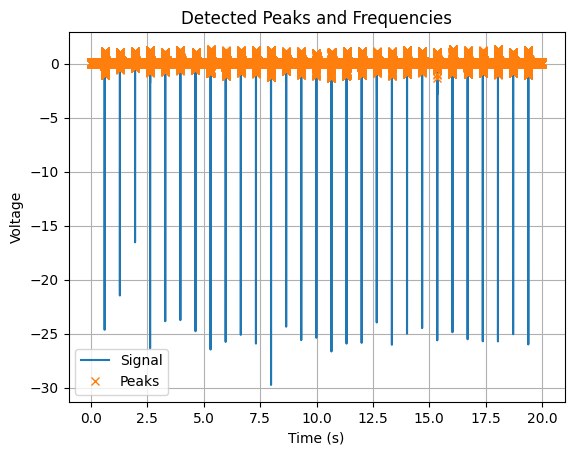

In [ ]:
# 파일 경로
file_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Leaf inspired DEG\0. 실험자료\2. Collecting data\250325_굴곡별\csv파일\l2.csv"

# 데이터 로드 (헤더 없음)
df = pd.read_csv(file_path, header=None)

# NaN 값 제거 및 컬럼 이름 지정
df.iloc[:30, 1] = np.nan
df.columns = ["Time", "Voltage"]
df = df.astype(float)  # 데이터 타입 변환

# 피크 검출 (최대 피크와 최소 피크)
height = 5 ################################### 최소 피크 전압 크기 조절 (노이즈 스케일 주의)######################### 
peaks_positive, _ = find_peaks(df["Voltage"], height, distance=100)  # 양의 피크
peaks_negative, _ = find_peaks(-df["Voltage"], height, distance=100)  # 음의 피크

# 모든 피크 인덱스 정렬
peaks = np.sort(np.concatenate((peaks_positive, peaks_negative)))

# 목표 샘플 개수
num_samples = 100000

# 피크 개수 확인
num_peaks = len(peaks)
print("Peak number:", num_peaks)

if num_peaks >= num_samples:
    # 피크 개수가 이미 충분하면 피크 중 일부만 선택
    selected_indices = np.sort(np.random.choice(peaks, num_samples, replace=False))
else:
    # 피크 유지, 나머지는 균등 샘플링
    num_non_peak_samples = num_samples - num_peaks
    non_peak_indices = np.setdiff1d(np.arange(len(df)), peaks)  # 피크 제외한 인덱스
    selected_non_peaks = np.linspace(0, len(non_peak_indices) - 1, num_non_peak_samples, dtype=int)
    selected_non_peaks = non_peak_indices[selected_non_peaks]

    # 최종 선택된 인덱스 (피크 + 균등 샘플링된 데이터)
    selected_indices = np.sort(np.concatenate((peaks, selected_non_peaks)))

# 필터링된 데이터
filtered_df = df.iloc[selected_indices]

# 그래프 설정
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)